# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Project ideas and thoughts:
- Predict whether a customer will respond to an offer in a given time
- Do not send offers to customers who would make a purchase anyway without the offer

In [88]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, plot_roc_curve
import joblib
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-whitegrid')

In [32]:
# read in the json files
offers = pd.read_json('data/portfolio.json', orient='records', lines=True)
customers = pd.read_json('data/profile.json', orient='records', lines=True)
events = pd.read_json('data/transcript.json', orient='records', lines=True)

# change column names and print df shape
offers.columns = ['reward','channels','min_spend','expire_days','offer_type','id']
customers.columns = ['gender','age','id','became_member_on','income']
events.columns = ['customer_id','event','value','hours_from_test']
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 17000 rows
events has 306534 rows


# Data Cleaning

In [33]:
# Clean the events data
for dic in events.value:
    if list(dic.keys()) == ['offer id']:
        dic['offer_id'] = dic.pop('offer id')

# Concat and transform the events data
temp = pd.DataFrame(events.value.to_list())
events = pd.concat([events,temp],axis=1)
events.rename(columns={'reward':'reward_received'},inplace=True)
events.drop('value',axis=1,inplace=True)
events.head()

,customer_id,event,hours_from_test,offer_id,amount,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [34]:
# Merge offers to events
events_offers = pd.merge(events, offers, how='left', left_on='offer_id', right_on='id')
events_offers = events_offers.query("event != 'transaction'") #include only offer related activities
events_offers.drop(['offer_id','id','amount','reward_received'],axis=1,inplace=True)
print(events_offers.offer_type.unique())
events_offers.head()

['bogo' 'discount' 'informational']


,customer_id,event,hours_from_test,reward,channels,min_spend,expire_days,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [35]:
# Function to create pivot table by offer type
def create_offer_pivot(offer):

    '''
    create a pivot table for a certain offer
    with the number of offers received, viewed and completed for each customer
    (discount, bogo, informational)
    '''

    df = events_offers[events_offers.offer_type == offer]
    df = df.groupby(['customer_id','event']).event.count().to_frame()
    df.columns = ['count']
    df.reset_index(inplace=True)
    df_pivot = pd.pivot(df, index='customer_id', columns='event', values='count')
    df_pivot.columns = [i.replace(' ','_') for i in df_pivot.columns]

    return df_pivot

# Function to return list of responded customer ids by offer type
def get_responded_ids(offer):
    '''
    get a list of customer ids
    who responded to a certain offer
    '''
    
    df = create_offer_pivot(offer)

    return df.dropna().index

In [36]:
# Create new feature - membership_days
customers.became_member_on = pd.to_datetime(customers.became_member_on, format='%Y%m%d')
most_recent = max(customers.became_member_on)
customers['membership_days'] = customers.became_member_on.apply(lambda x: most_recent - x).dt.days

# Create target variables - whether the customer responded to offer
customers['discount_response'] = customers.id.isin(get_responded_ids('discount')).astype(int)
customers['bogo_response'] = customers.id.isin(get_responded_ids('bogo')).astype(int)
customers.head()

,gender,age,id,became_member_on,income,membership_days,discount_response,bogo_response
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,1,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,0,1
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,0,0


# EDA - Who responds to offers?
- Income Level
- Gender/Age
- Membership Length

# Examine offer response by age

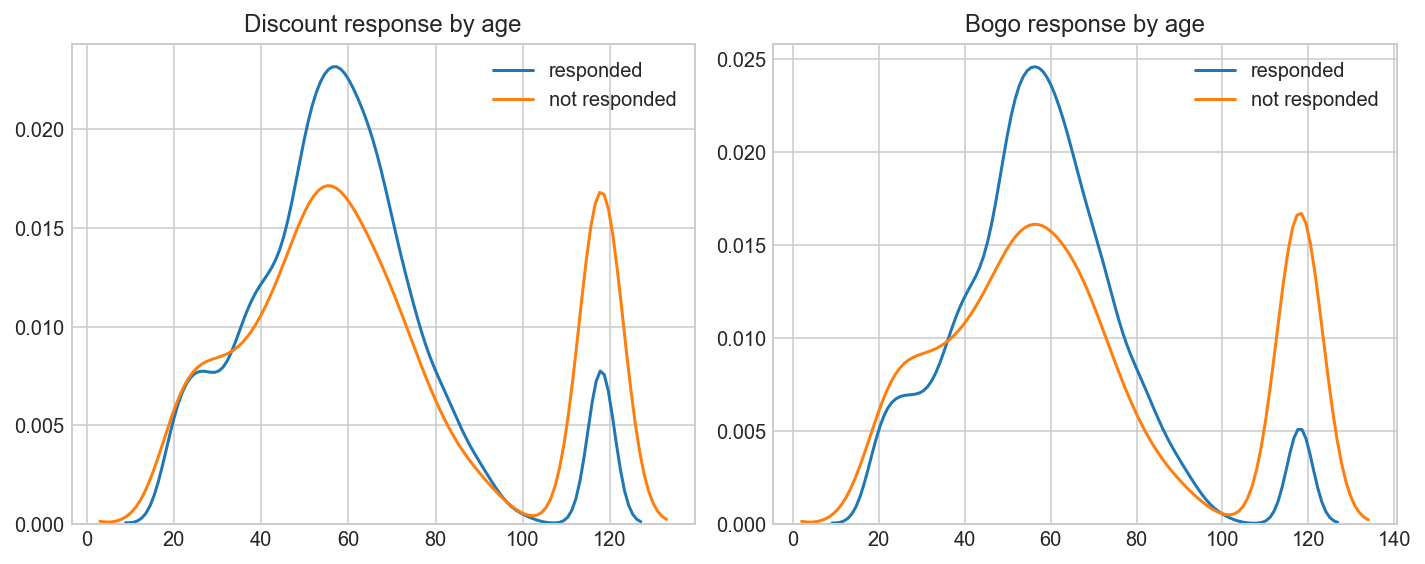

In [6]:
# Plot age distribution comparison
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.kdeplot(customers.query("discount_response == 1").age, label='responded');
sns.kdeplot(customers.query("discount_response == 0").age, label='not responded');
plt.title('Discount response by age');

plt.subplot(1,2,2)
sns.kdeplot(customers.query("bogo_response == 1").age, label='responded');
sns.kdeplot(customers.query("bogo_response == 0").age, label='not responded');
plt.title('Bogo response by age');
plt.tight_layout()

# Examine offer response by days of membership

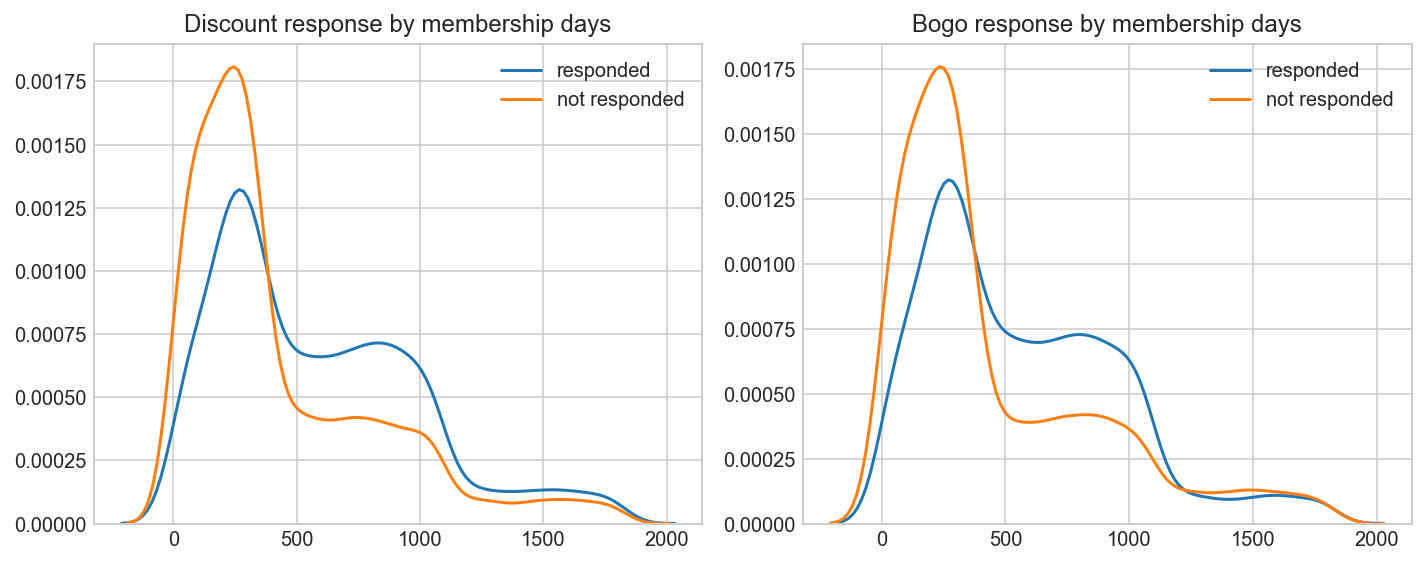

In [7]:
# Plot membership_days distribution comparison
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.kdeplot(customers.query("discount_response == True").membership_days, label='responded');
sns.kdeplot(customers.query("discount_response == False").membership_days, label='not responded');
plt.title('Discount response by membership days');

plt.subplot(1,2,2)
sns.kdeplot(customers.query("bogo_response == True").membership_days, label='responded');
sns.kdeplot(customers.query("bogo_response == False").membership_days, label='not responded');
plt.title('Bogo response by membership days');
plt.tight_layout()

# Examine offer response by income

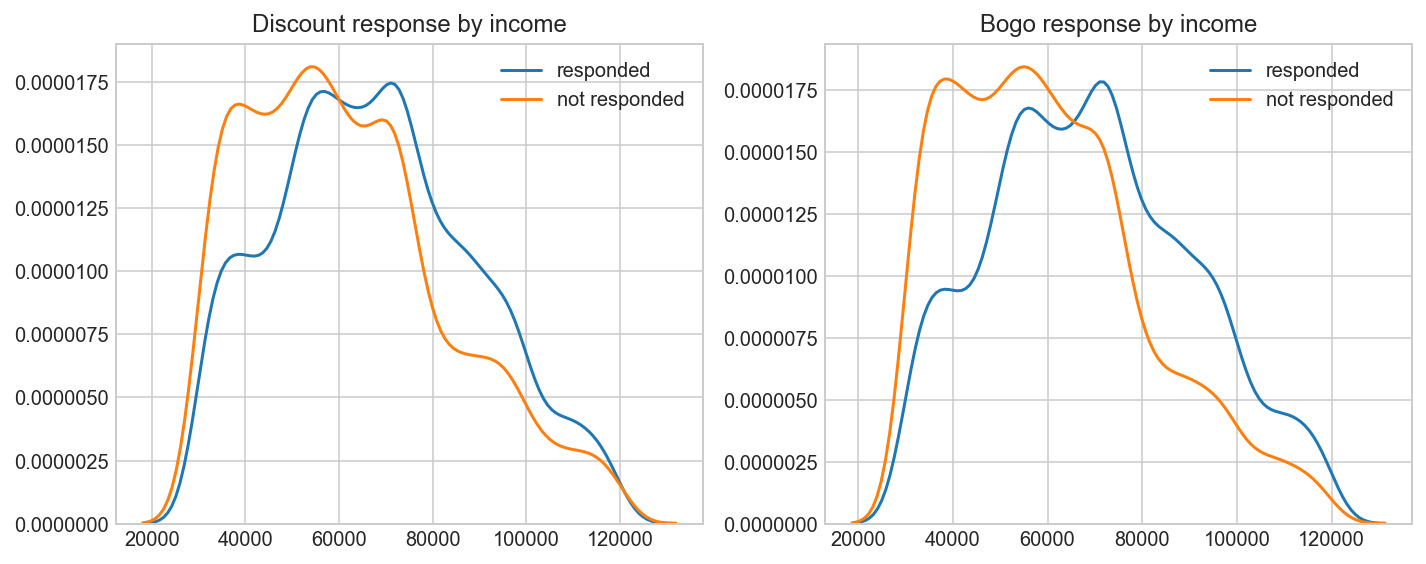

In [8]:
# Plot income distribution comparison
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.kdeplot(customers.query("discount_response == True").income, label='responded');
sns.kdeplot(customers.query("discount_response == False").income, label='not responded');
plt.title('Discount response by income');

plt.subplot(1,2,2)
sns.kdeplot(customers.query("bogo_response == True").income, label='responded');
sns.kdeplot(customers.query("bogo_response == False").income, label='not responded');
plt.title('Bogo response by income');
plt.tight_layout()

# Examine Offer response by gender

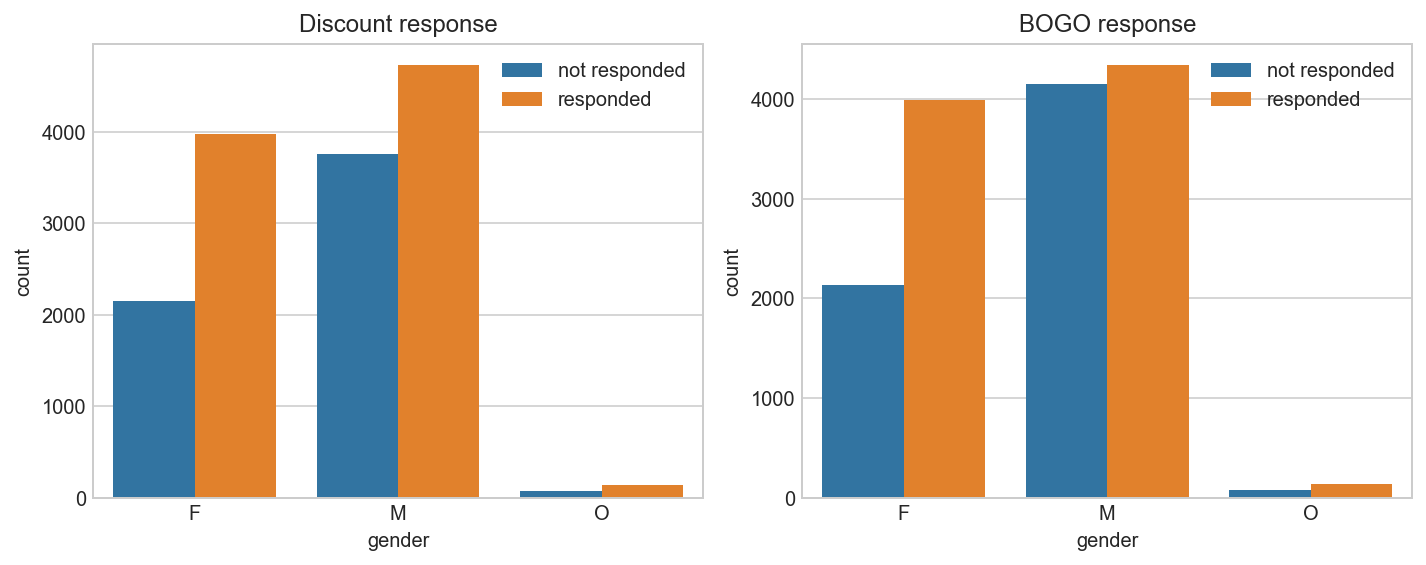

In [9]:
# Plot barplot comparisons
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(data=customers, x='gender', hue='discount_response');
plt.title('Discount response');
plt.legend(['not responded','responded'])

plt.subplot(1,2,2)
sns.countplot(data=customers, x='gender', hue='bogo_response');
plt.title('BOGO response')
plt.legend(['not responded','responded'])
plt.tight_layout()

# Additional data cleaning before modeling

In [37]:
# Examine the ratios of target classes to decide on the classification metrics
# Accuracy seems like a good metric for balanced classes
print('discount response class ratios:')
print(customers.discount_response.value_counts() / len(customers))
print('\n')
print('bogo response class ratios')
print(customers.bogo_response.value_counts() / len(customers))

discount response class ratios:
1    0.553176
0    0.446824
Name: discount_response, dtype: float64


bogo response class ratios
1    0.517882
0    0.482118
Name: bogo_response, dtype: float64


In [38]:
# The ratio of responses in the null values in 'gender' is more imbalanced than not null
print('discount response class for null values in gender')
print(customers[customers.gender.isnull()].discount_response.value_counts())
print('\n')
print('discount response class for not-null values in gender')
print(customers[customers.gender.notnull()].discount_response.value_counts())

# As a result, convert the null values into another class/feature for modeling
customers.gender.fillna('unknown',inplace=True)

# Impute null values in income with median income
customers.income.fillna(np.median(customers.income.dropna()),inplace=True)

discount response class for null values in gender
0    1617
1     558
Name: discount_response, dtype: int64


discount response class for not-null values in gender
1    8846
0    5979
Name: discount_response, dtype: int64


 # Build Models to classify both discount_response and bogo_response
- By predicting whether a customer will respond to a certain type of offer (discount / bogo), we can build focused marketing campaigns to maximize returns

## Notes:
- 55% of customers responded to discount offers while 45% didn't respond
- 51% of customers responded to bogo offers while 48 percent didn't respond
- Although classes are balanced, I would still choose F1 score as the metric
- Because I'd like to focus on customers who responded, and don't mind if the model misclassifies not-responded customers

In [39]:
# Split customers data into X and y
X = customers[['gender','age','income','membership_days']]
y = customers['discount_response']

# Convert categorical features into dummy variables
X = pd.get_dummies(X)

# Examine cross validation results in f1 scores

In [28]:
# print('cross validation scores for AdaBoost:', cross_val_score(AdaBoostClassifier(), X, y, scoring="f1", cv=5))
# print('cross validation scores for RandomForest:', cross_val_score(RandomForestClassifier(), X, y, scoring='f1', cv=5))
# print('cross validation scores for LogisticRegression:', cross_val_score(LogisticRegression(), X, y, scoring='f1', cv=5))

# Compare ROC AUC for both target variable (discount, bogo)

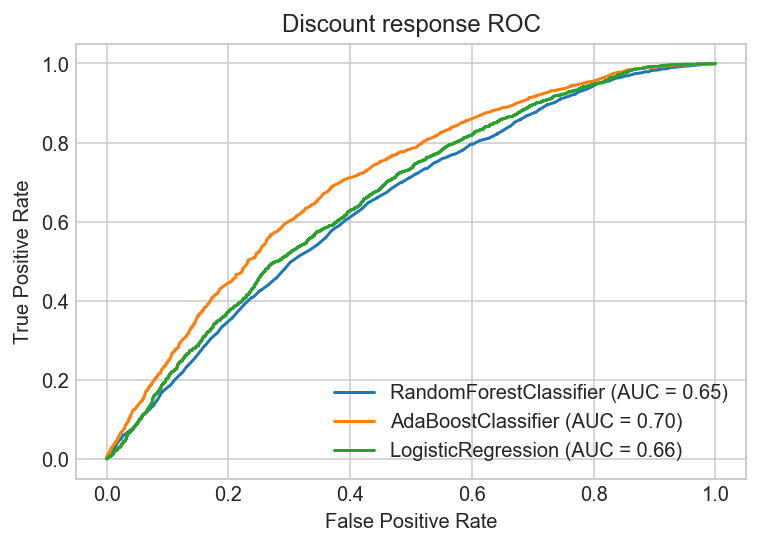

In [40]:
# Set discount_response as the target variable
y = customers['discount_response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train three models
log_reg = LogisticRegression().fit(X_train, y_train)
rfc = RandomForestClassifier().fit(X_train, y_train)
adaboost = AdaBoostClassifier().fit(X_train, y_train)

# Plot ROC comparisons
temp = plot_roc_curve(rfc, X_test, y_test)
plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_);
plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
plt.title('Discount response ROC');

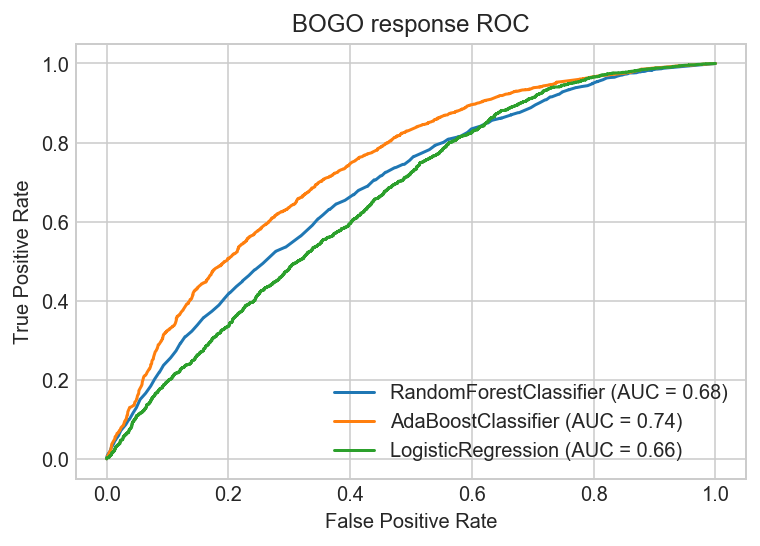

In [41]:
# Set bogo_response as the target variable
y = customers['bogo_response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train three models
log_reg = LogisticRegression().fit(X_train, y_train)
rfc = RandomForestClassifier().fit(X_train, y_train)
adaboost = AdaBoostClassifier().fit(X_train, y_train)

# Plot ROC comparison
temp = plot_roc_curve(rfc, X_test, y_test)
plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_);
plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
plt.title('BOGO response ROC');

# Use GridSearchCV to find the best parameters for AdaBoost

In [59]:
# Get available parameters
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [91]:
y = customers['bogo_response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

bogo_cv = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1', return_train_score=True)
bogo_cv.fit(X_train, y_train)
print(f'best parameters: {bogo_cv.best_params_}')
# print(bogo_cv.cv_results_)
y_pred = bogo_cv.predict(X_test)
print(f'f1 score on the test data: {f1_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 30}
f1 score on the test data: 0.7269287365986966


In [92]:
y = customers['discount_response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

discount_cv = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1', return_train_score=True)
discount_cv.fit(X_train, y_train)
print(f'best parameters: {discount_cv.best_params_}')
# print(discount_cv.cv_results_)
y_pred = discount_cv.predict(X_test)
print(f'f1 score on the test data: {f1_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 10}
f1 score on the test data: 0.7421795133919444


### Find the optimal probability threshold for the highest F1 scores
- In practice, we can lower the threshold because there is little harm to send offers to those who won't respond

In [93]:
def find_best_threshold(model, plot=False):

    # create a hash table of thresholds vs f1 scores
    res = dict()
    y_proba_pred = model.predict_proba(X_test)[:,1]

    for threshold in np.linspace(0,1):
        res[threshold] = f1_score(y_test, [1 if p > threshold else 0 for p in y_proba_pred])

    # Find the optimal probability thresholds for the max f1 score
    for key,value in res.items():
        if value == max(res.values()):
            print(key)

    if plot == True:
        # plot probability threshold VS F1 scores
        plt.plot(list(res.keys()), list(res.values()));
        plt.title('F1 scores by probability thresholds');

0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041


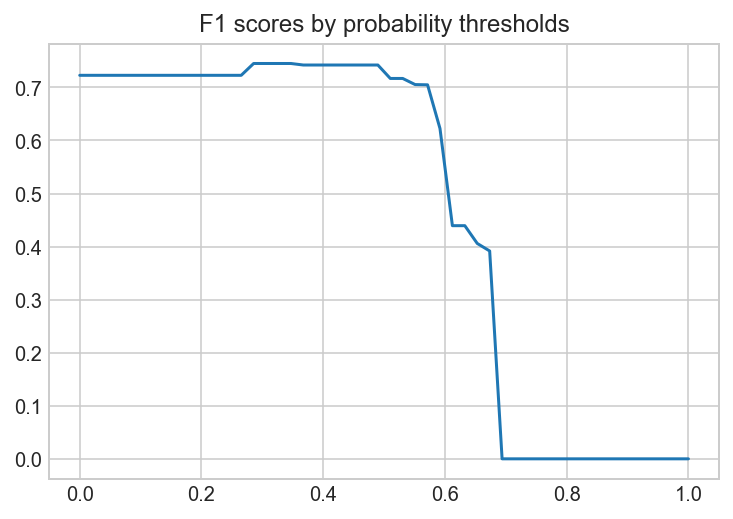

In [98]:
# The best threshold for predicting bogo response is between 0.28 and 0.34 for this test data
find_best_threshold(bogo_cv, plot=True)

0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041
0.36734693877551017
0.3877551020408163
0.4081632653061224
0.42857142857142855
0.44897959183673464


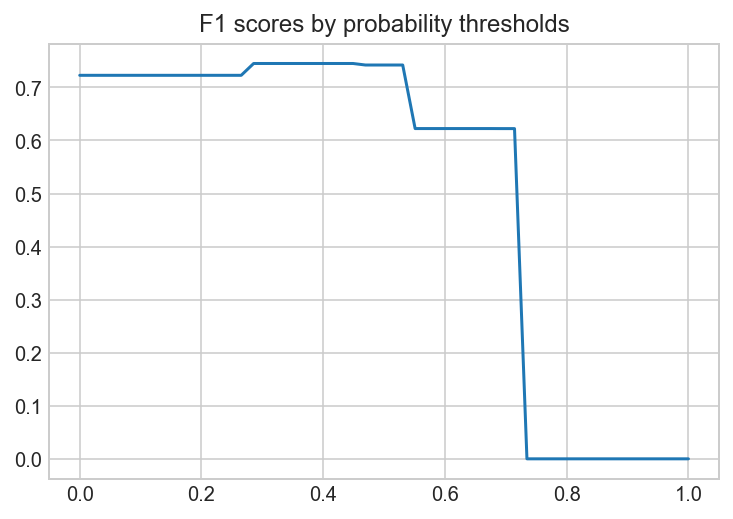

In [101]:
# The best threshold for predicting discount response is between 0.28 and 0.45 for this test data
find_best_threshold(discount_cv, plot=True)

In [102]:
# Save the two models for classifying discount and bogo responses
joblib.dump(discount_cv, 'discount_clf.pkl')
joblib.dump(bogo_cv, 'bogo_clf.pkl')

['bogo_clf.pkl']